In [3]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
import datetime
%matplotlib inline

In [4]:
def create_and_train_autoencoder(input_data, epochs=10, batch_size=32):
    input_layer = Input(shape=(1,))
    encoded = Dense(64, activation='relu')(input_layer)
    decoded = Dense(1, activation='linear')(encoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    #autoencoder.save("autoencoder_model.h5")
    print(autoencoder.summary())

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    history = autoencoder.fit(input_data, input_data, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=0.3, callbacks=[tensorboard_callback])
    
    print("Training Information:")
    print(f"Number of training epochs: {epochs}")
    print(f"Batch size: {batch_size}")
    
    history = autoencoder.history.history
    
    print("\nTraining Metrics:")
    for metric_name, values in history.items():
        print(f"{metric_name}: {values[-1]}")
        
    plt.figure(figsize=(12, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return autoencoder, autoencoder.layers[1]

In [5]:
def generate_embeddings_around_time(ecg_data, time_x, sample_rate, embedding_size=32, time_window=2):
    x_index = int(time_x * sample_rate)
    data_x = ecg_data[x_index - time_window * sample_rate : x_index + time_window * sample_rate]
    data_x_reshaped = data_x.reshape(-1, 1)

    autoencoder, encoder = create_and_train_autoencoder(data_x_reshaped)
    
    encoder_model = keras.models.Model(inputs=autoencoder.input, outputs=encoder(autoencoder.input))
    
    embeddings_x = encoder_model.predict(data_x_reshaped)
    
    reconstructed_data = autoencoder.predict(data_x_reshaped)
    
    return embeddings_x, reconstructed_data


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 193 (772.00 Byte)
Trainable params: 193 (772.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
44/44 [==============================] - 0s 3ms/step - loss: 0.0426 - val_loss: 0.0154
Epoch 2/10
44/44 [==============================] - 0s 981us/step - loss: 0.0083 - val_loss: 0.0028
Epoch 3/10
44/44 [==============================] - 0s 890us/step - loss: 0.0021 - v

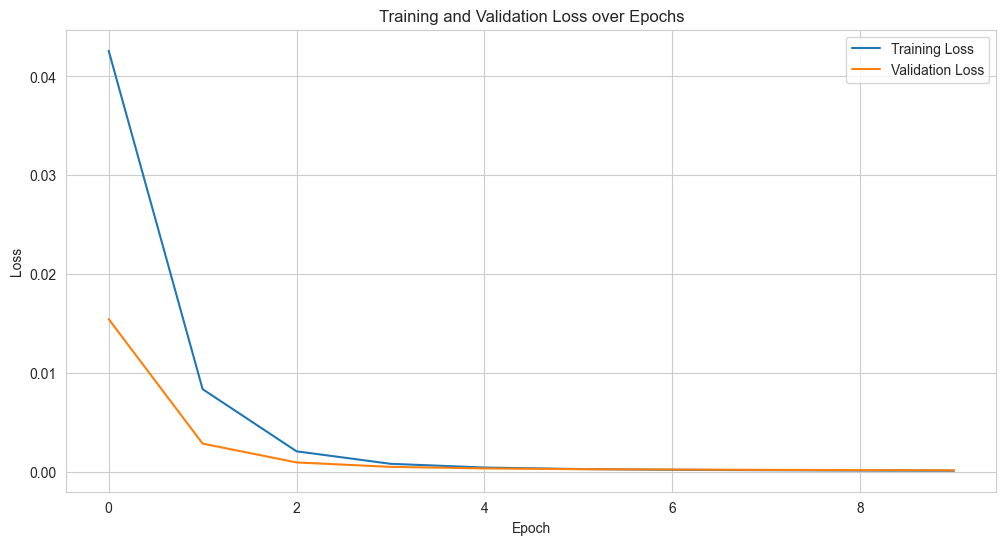

63/63 [==============================] - 0s 653us/step


In [6]:
duration_minutes = 1
sample_rate = 1000
ecg_signal = nk.ecg_simulate(duration=duration_minutes * 60, noise=0.01, heart_rate=100)

time_x_user = 1 * 60

embeddings_x_user, reconstructed_data_user = generate_embeddings_around_time(ecg_signal, time_x_user, sample_rate=sample_rate)


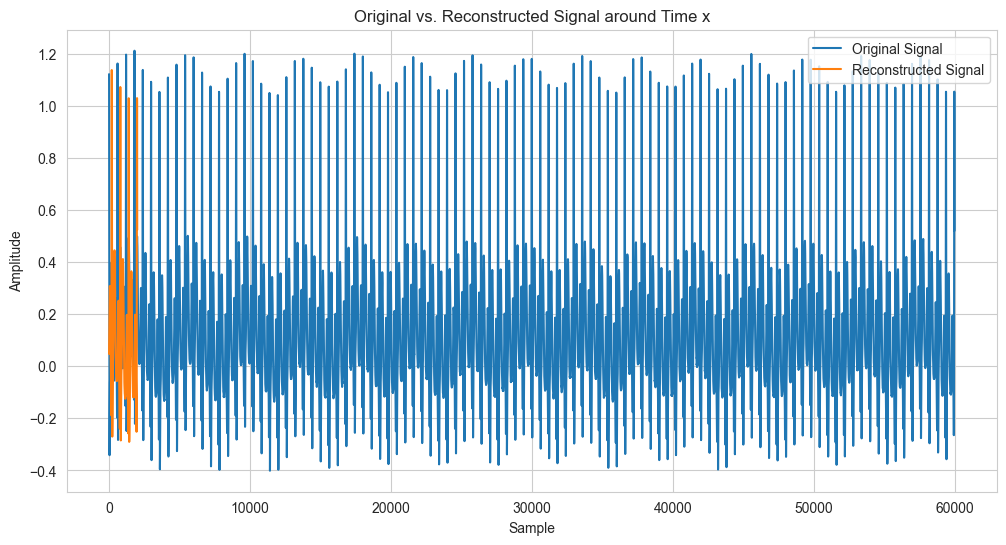

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(ecg_signal, label='Original Signal')
plt.plot(reconstructed_data_user, label='Reconstructed Signal')

index_to_plot = int(time_x_user * sample_rate)
if index_to_plot < len(reconstructed_data_user):
    plt.scatter(index_to_plot, reconstructed_data_user[index_to_plot], color='red', label='Time x')

plt.title('Original vs. Reconstructed Signal around Time x')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

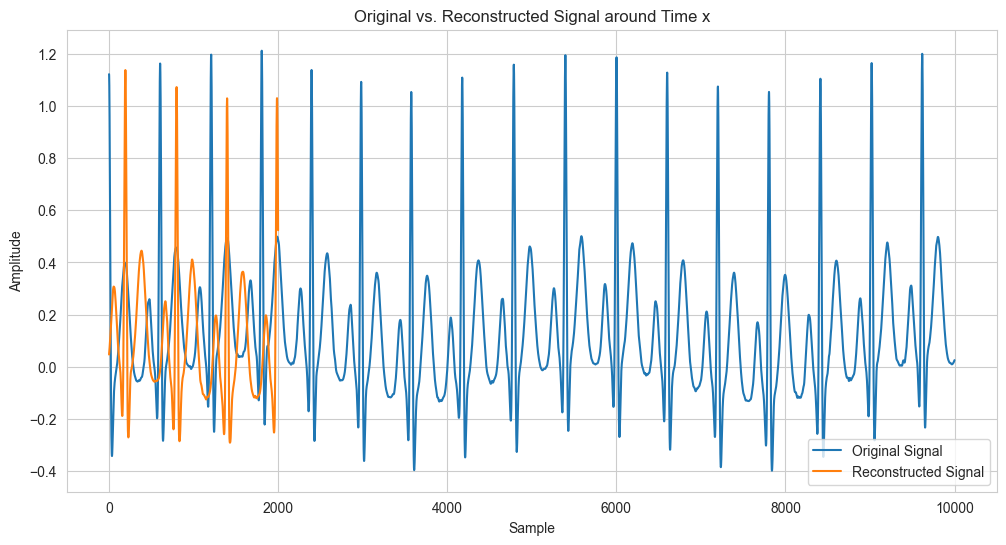

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(ecg_signal[:10000], label='Original Signal')
plt.plot(reconstructed_data_user[:10000], label='Reconstructed Signal')

index_to_plot = int(time_x_user * sample_rate)
if index_to_plot < len(reconstructed_data_user):
    plt.scatter(index_to_plot, reconstructed_data_user[index_to_plot], color='red', label='Time x')

plt.title('Original vs. Reconstructed Signal around Time x')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [9]:
print("Embeddings no tempo x:", embeddings_x_user)

Embeddings no tempo x: [[0.         0.09071404 0.06925292 ... 0.06941489 0.         0.05995541]
 [0.         0.09044521 0.07009554 ... 0.07004208 0.         0.06050226]
 [0.         0.09016034 0.0709884  ... 0.07070667 0.         0.06108172]
 ...
 [0.         0.04136825 0.22391795 ... 0.1845385  0.         0.1603315 ]
 [0.         0.0469044  0.20656593 ... 0.17162268 0.         0.14907022]
 [0.         0.05261319 0.18867281 ... 0.15830408 0.         0.13745774]]


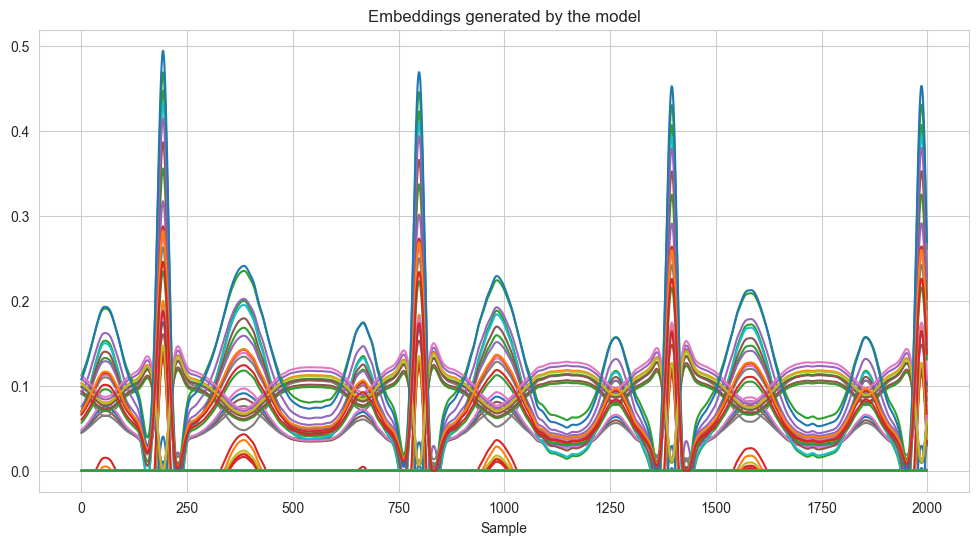

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(embeddings_x_user)
plt.title('Embeddings generated by the model')
plt.xlabel('Sample')
plt.show()

In [11]:
#!tensorboard --logdir logs/fit